## Titanic Competition with Neural Networks

Imported libraries and train, test datas

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Dataset Overview

The Titanic dataset contains information about passengers aboard the Titanic, including features like age, sex, passenger class, fare, number of siblings/spouses, number of parents/children aboard, and whether they survived.
Our goal is to use this structured data to predict survival outcomes using a neural network model.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Creating FamilySize: Combining the number of siblings/spouses (SibSp) and parents/children (Parch). Larger families may have had different survival chances.

In [4]:
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"]
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"]

Created IsAlone: Identifies passengers traveling alone (no family). Solo travelers may have faced different risks.

In [5]:
train_data["IsAlone"] = (train_data["FamilySize"] == 0).astype(np.float32)
test_data["IsAlone"] = (test_data["FamilySize"] == 0).astype(np.float32)

Edited Title: Extracted from the passenger's name (e.g., Mr., Mrs., Miss) to capture social status or demographic clues.

In [6]:
# Reorganize titles
train_data["Title"] = train_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test_data["Title"] = test_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

# Grouping rare titles
for df in [train_data, test_data]:
    df["Title"] = df["Title"].replace(
        ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 
         'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df["Title"] = df["Title"].replace('Mlle', 'Miss')
    df["Title"] = df["Title"].replace('Ms', 'Miss')
    df["Title"] = df["Title"].replace('Mme', 'Mrs')

In [7]:
# Label encoder
le = LabelEncoder()
train_data["Title"] = le.fit_transform(train_data["Title"])
test_data["Title"] = le.transform(test_data["Title"])

## Train Data Preprocessing

NaN values filled, some categorcal values converted to float32 type

In [8]:
train = train_data[["Survived","Pclass","Sex","Age","SibSp","Parch","Fare"]]

Age: Replaced with median age — because age distribution is skewed and median is more robust to outliers.

In [9]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].median())

In [10]:
train_data["Sex"] = train_data["Sex"].map({'male':0,'female':1}).astype(np.float32)

Fare: Applied log1p transformation to reduce skewness in the fare amounts.

In [11]:
# log1p transformation
train_data["Fare"] = np.log1p(train_data["Fare"])

In [12]:
X = train_data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone","Title"]].values.astype(np.float32)
y = train_data["Survived"].values.astype(np.float32)

### Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Normalization

In [14]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Creating a Model

Creating a nn model to predict survivors 

In [15]:
model = Sequential()

model.add(Dense(units = 16, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(units = 8, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["Accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The model was trained over 60 epochs with a batch size of 20.
We monitored training and validation loss/accuracy.

In [16]:
model.fit(x=X_train, y=y_train, epochs=60, batch_size=20, validation_data=(X_test,y_test),verbose=1)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - Accuracy: 0.4712 - loss: 0.7149 - val_Accuracy: 0.5410 - val_loss: 0.6856
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.5684 - loss: 0.6792 - val_Accuracy: 0.6418 - val_loss: 0.6758
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.6680 - loss: 0.6540 - val_Accuracy: 0.6530 - val_loss: 0.6638
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.6980 - loss: 0.6416 - val_Accuracy: 0.6679 - val_loss: 0.6510
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Accuracy: 0.6451 - loss: 0.6501 - val_Accuracy: 0.7015 - val_loss: 0.6354
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.6514 - loss: 0.6280 - val_Accuracy: 0.7090 - val_loss: 0.6201
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.6801 - loss: 0.6206 - val_Accuracy: 0.7052 - val_loss: 0.6060
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Accuracy: 0.7053 - loss: 0.5949 - val_Accuracy: 0.7537 - val_loss

### Model Loss

In [17]:
history = pd.DataFrame(model.history.history)
history.head()

,Accuracy,loss,val_Accuracy,val_loss
0,0.475120,0.705954,0.541045,0.685619
1,0.592295,0.672218,0.641791,0.675771
2,0.650080,0.655600,0.652985,0.663841
3,0.672552,0.648496,0.667910,0.650968
4,0.654896,0.648110,0.701493,0.635391


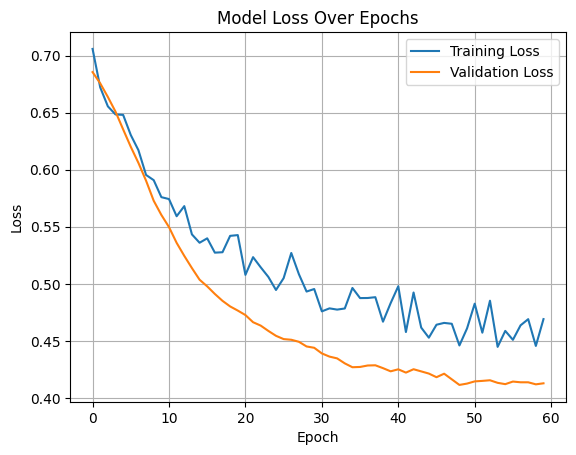

In [18]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Accuracy

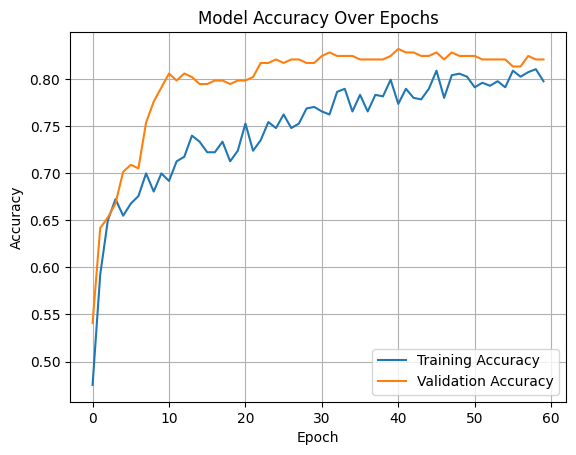

In [19]:
plt.plot(history['Accuracy'], label='Training Accuracy')
plt.plot(history['val_Accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Prediction From Test Data

### Test Data Preprocessing

NaN values filled, categorical values converted to float32 data type 

In [20]:
test_data['Age'] = test_data['Age'].fillna(train["Age"].median())
test_data['Fare'] = test_data['Fare'].fillna(train["Fare"].median())
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1}).astype(np.float32)
test_data["Fare"] = np.log1p(test_data["Fare"])

In [21]:
X_test_feature = test_data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone","Title"]].values.astype(np.float32)

In [22]:
X_test_feature_scaled = scaler.transform(X_test_feature)

### Prediction

In [23]:
pred_prob = model.predict(X_test_feature_scaled)
predictions = (pred_prob > 0.5).astype(int).reshape(-1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [24]:
submission_df = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})

# Read to CSV
submission_df.to_csv('titanic_submission.csv', index=False)
print("✅ 'titanic_submission.csv' has created")

✅ 'titanic_submission.csv' has created
